# Taiko Priority Fee Analysis

## Methodology
- Collect batch settlement costs on devnet for current Taiko mainnet TPS (~20 TPS), gas per block ~= 773000
- Collect mainnet base fee over a month

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:

# Load the CSV file
df = pd.read_csv('holesky__transactions__04055500_to_04061065.csv')

print("Dataset Overview:")
print(f"Columns: {list(df.columns)}")

Dataset Overview:
Columns: ['block_number', 'transaction_hash', 'gas_limit', 'gas_used', 'gas_price', 'max_priority_fee_per_gas', 'max_fee_per_gas', 'n_input_bytes', 'timestamp']


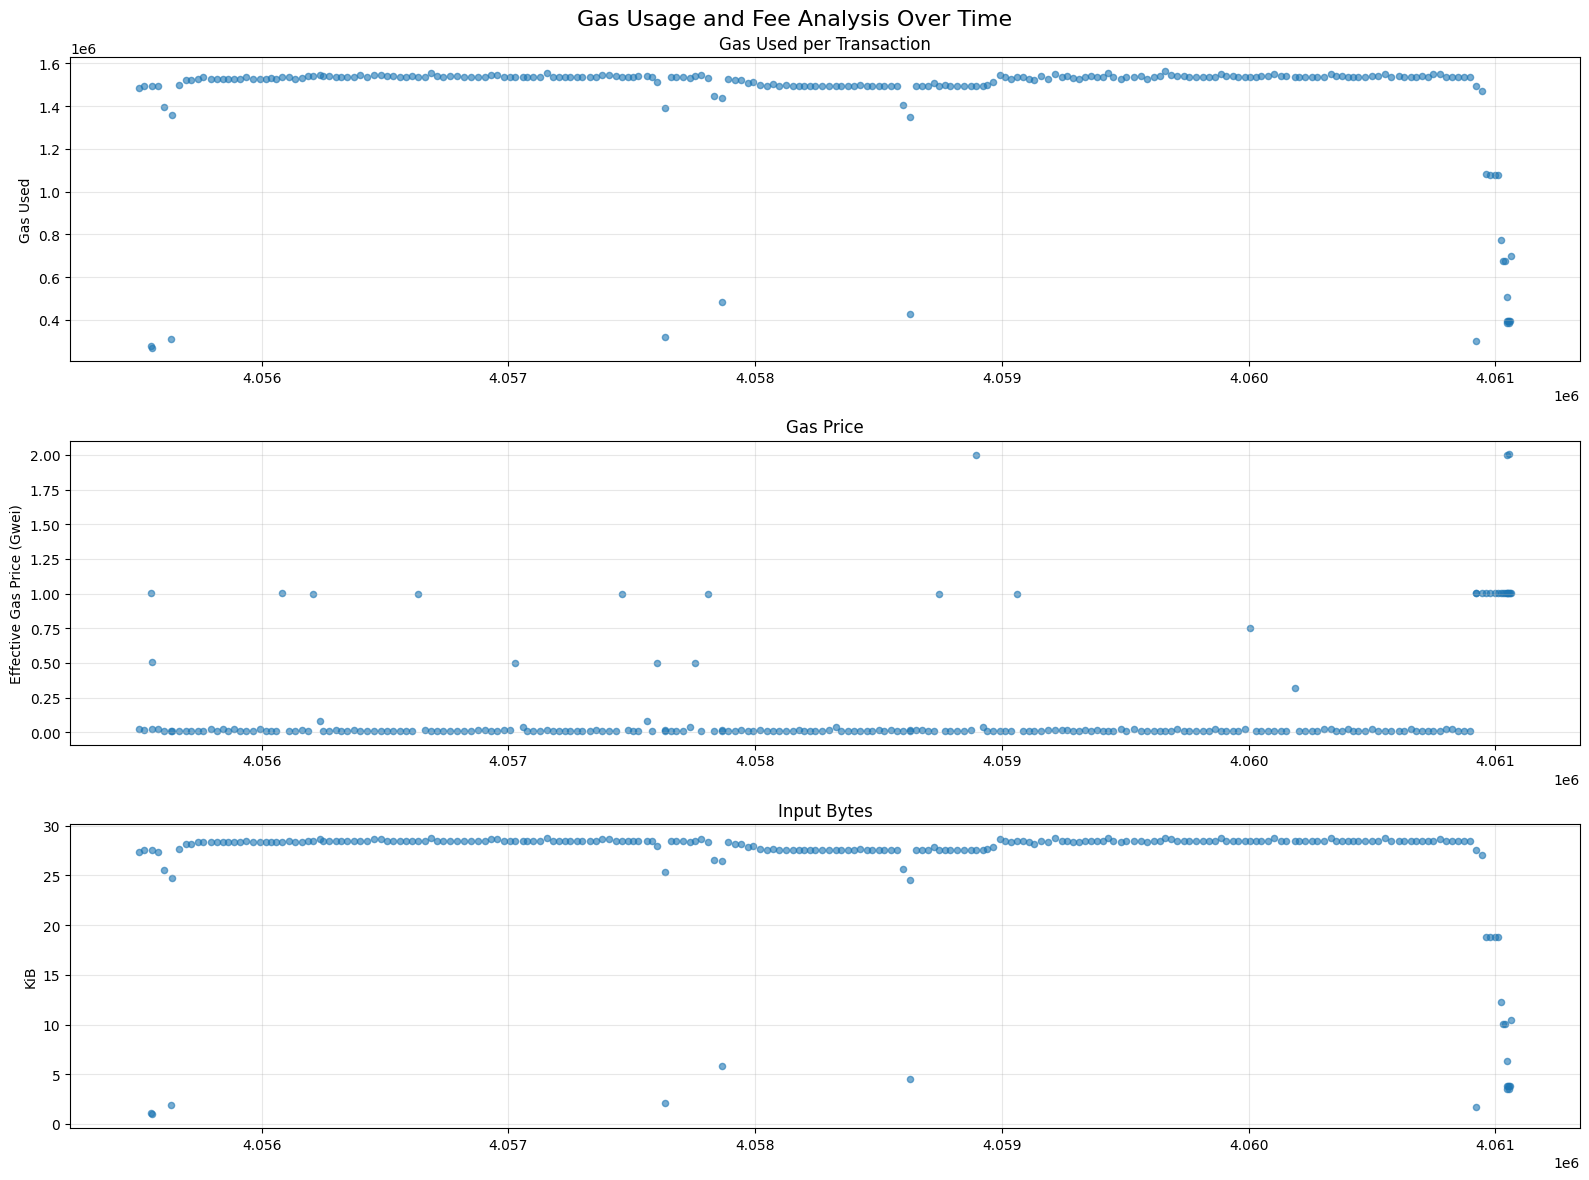

In [45]:
# Basic data exploration and cleaning
# Use block_number instead of timestamp for time series
# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Gas Usage and Fee Analysis Over Time', fontsize=16)

# Plot 1: Gas Used over time
axes[0].scatter(df['block_number'], df['gas_used'], alpha=0.6, s=20)
axes[0].set_ylabel('Gas Used')
axes[0].set_title('Gas Used per Transaction')
axes[0].grid(True, alpha=0.3)

# Plot 2: Base Fee over time (gas_price - max_priority_fee_per_gas)
axes[1].scatter(df['block_number'], df['gas_price'] / 1e9, alpha=0.6, s=20)  # Convert to Gwei
axes[1].set_ylabel('Effective Gas Price (Gwei)')
axes[1].set_title('Gas Price')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(df['block_number'], df['n_input_bytes'] / 1024, alpha=0.6, s=20)
axes[2].set_ylabel('KiB')
axes[2].set_title('Input Bytes')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
basefee_df = pd.read_csv('ethereum__blocks__22553417_to_22779884.csv')

basefee_df.head()

,block_number,gas_used,timestamp,base_fee_per_gas
0,22553417,30822181,1748098391,990446464
1,22553418,17503716,1748098403,1078638712
2,22553419,13288239,1748098415,1074921274
3,22553420,20914886,1748098427,1039749246
4,22553421,21309402,1748098439,1060648801


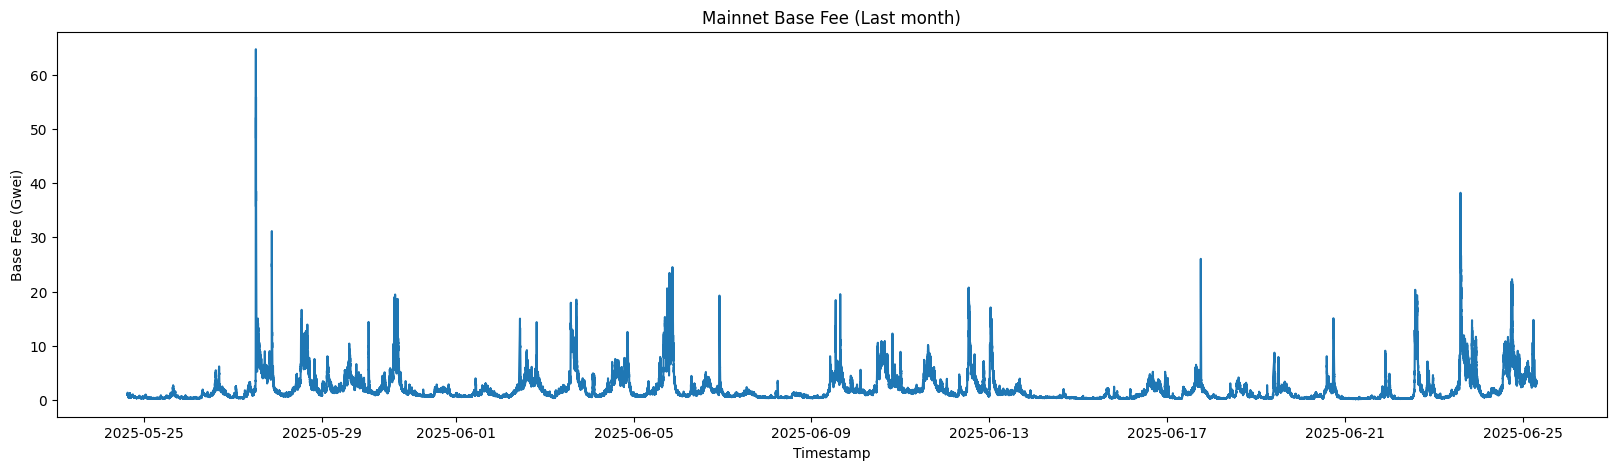

In [6]:
basefee_df['timestamp'] = pd.to_datetime(basefee_df['timestamp'], unit='s')

plt.figure(figsize=(20, 5))
plt.title('Mainnet Base Fee (Last month)')
plt.plot(basefee_df['timestamp'], basefee_df['base_fee_per_gas'] / 1e9)
plt.ylabel('Base Fee (Gwei)')
plt.xlabel('Timestamp')
plt.show()

In [46]:
logs_df = pd.read_csv('holesky__logs__04055500_to_04061065.csv')

logs_df.head()

,block_number,transaction_index,log_index,transaction_hash,address,topic0,topic1,topic2,topic3,data,n_data_bytes,chain_id
0,4055501,3,12,0x7466d7b0422ebd3927e2655d426481d1389e1e868dba...,0x174baa701d0198e0937c2ca113bc5bc30a01574c,0x9eb7fc80523943f28950bbb71ed6d584effe3e1e02ca...,NaN,NaN,NaN,0x00000000000000000000000000000000000000000000...,28192,17000
1,4055522,4,91,0x2e1b4c3004d080a240e61022bfa30986f58eb2a08eb2...,0x174baa701d0198e0937c2ca113bc5bc30a01574c,0x9eb7fc80523943f28950bbb71ed6d584effe3e1e02ca...,NaN,NaN,NaN,0x00000000000000000000000000000000000000000000...,28352,17000
2,4055552,2,12,0xb9e666ee8e27e531b76e0a7ed310bf98f748a0dff471...,0x174baa701d0198e0937c2ca113bc5bc30a01574c,0x9eb7fc80523943f28950bbb71ed6d584effe3e1e02ca...,NaN,NaN,NaN,0x00000000000000000000000000000000000000000000...,1248,17000
3,4055554,5,11,0x8e875d255324d1a864a2479eba0efb768e155f27a94a...,0x174baa701d0198e0937c2ca113bc5bc30a01574c,0x9eb7fc80523943f28950bbb71ed6d584effe3e1e02ca...,NaN,NaN,NaN,0x00000000000000000000000000000000000000000000...,1088,17000
4,4055557,2,8,0x4e8894eaf47a137a36daddf6a04f49009b903963ce1d...,0x174baa701d0198e0937c2ca113bc5bc30a01574c,0x9eb7fc80523943f28950bbb71ed6d584effe3e1e02ca...,NaN,NaN,NaN,0x00000000000000000000000000000000000000000000...,28352,17000


In [47]:
from web3 import Web3
from web3.datastructures import AttributeDict
from web3._utils.events import get_event_data
import json

w3 = Web3(Web3.HTTPProvider("http://remotebeast:42545"))

l2_w3 = Web3(Web3.HTTPProvider("http://mk1-masaya-dev-replica-0:8545"))

with open('BatchProposed.abi.json', 'r') as f:
    event_abi = json.load(f)

def extract_batch_info(row):
    dummy_log = AttributeDict({
        "topics": [Web3.to_bytes(hexstr=row['topic0'])],
        "data": Web3.to_bytes(hexstr=row['data']),
        'logIndex': 0,
        'transactionIndex': 0,
        'transactionHash': '0x0000000000000000000000000000000000000000000000000000000000000000',
        'blockHash': '0x0000000000000000000000000000000000000000000000000000000000000000',
        'blockNumber': 0,
        'address': '0x0000000000000000000000000000000000000000',
        'removed': False,
    })
    decoded_event = get_event_data(w3.codec, event_abi, dummy_log)['args']
    batch_info = decoded_event['info']

    return batch_info['lastBlockId'], len(batch_info['blocks']), sum(block['numTransactions'] for block in batch_info['blocks'])

def get_l2_balance(address, block_number):
    return l2_w3.eth.get_balance(l2_w3.to_checksum_address(address), block_identifier=block_number)

logs_df['last_block_id'], logs_df['num_blocks'], logs_df['num_transactions'] = zip(*logs_df.apply(extract_batch_info, axis=1))

logs_df['balance_before'] = logs_df.apply(lambda row: get_l2_balance('0x00a00800c28f2616360DCfaDeE02d761D14Ad94e', row['last_block_id'] - row['num_blocks']), axis=1)

logs_df['balance_after'] = logs_df.apply(lambda row: get_l2_balance('0x00a00800c28f2616360DCfaDeE02d761D14Ad94e', row['last_block_id']), axis=1)

logs_df['balance_change'] = logs_df['balance_after'] - logs_df['balance_before']


In [48]:
new_df = logs_df.merge(df, on=['transaction_hash', 'block_number'], how='inner')

new_df['batch_cost'] = new_df['gas_price'] * new_df['gas_used']

new_df.head(20)

final_df = new_df.drop(columns=['address', 'data', 'transaction_index', 'log_index', 'topic0', 'topic1', 'topic2', 'topic3', 'chain_id'])
final_df.head(20)

,block_number,transaction_hash,n_data_bytes,last_block_id,num_blocks,num_transactions,balance_before,balance_after,balance_change,gas_limit,gas_used,gas_price,max_priority_fee_per_gas,max_fee_per_gas,n_input_bytes,timestamp,batch_cost
0,4055501,0x7466d7b0422ebd3927e2655d426481d1389e1e868dba...,28192,604430,170,5058,43560351339220949500,43571504229220949500,11152890000000000,1516303,1484711,22186141,10000001,35096351,28036,1750755444,32940007590251
1,4055522,0x2e1b4c3004d080a240e61022bfa30986f58eb2a08eb2...,28352,604601,171,5062,43571504229220949500,43582665939220949500,11161710000000000,1523899,1492189,20122732,10000001,33438162,28196,1750755828,30026919340348
2,4055552,0xb9e666ee8e27e531b76e0a7ed310bf98f748a0dff471...,1248,604603,2,385,43582665939220949500,43583514864220949500,848925000000000,289668,277242,1003589323,1000000000,1009046011,1156,1750756296,278237111087166
3,4055554,0x8e875d255324d1a864a2479eba0efb768e155f27a94a...,1088,604604,1,120,43583514864220949500,43583779464220949500,264600000000000,282688,270371,504009095,500857450,508933427,996,1750756320,136269443024245
4,4055557,0x4e8894eaf47a137a36daddf6a04f49009b903963ce1d...,28352,604775,171,5082,43583779464220949500,43594985274220949500,11205810000000000,3053598,1495043,22633082,20000002,34182406,28196,1750756356,33837430812526
5,4055579,0x2ac2c7e8f3ef1c7927490ba18700df856f3a02c400b8...,28192,604945,170,5060,43594985274220949500,43606142574220949500,11157300000000000,3055802,1496128,21722046,20000002,29220850,28036,1750756716,32498961237888
6,4055605,0x12d00d2793ec73c2ab448f50258f3e4b0e7536b409d9...,26272,605103,158,5054,43606142574220949500,43617286644220949500,11144070000000000,1428041,1397828,11761817,10000001,13132861,26116,1750757088,16440997133476
7,4055633,0x423316e676355cb8da82eccace5a7cce4456fa0f7d86...,2048,605110,7,198,43617286644220949500,43617723234220949500,436590000000000,321733,308806,11521046,10000001,13551395,1956,1750757508,3557768131076
8,4055635,0xbcaf73b9ef824a41deb0de0b679962f2bfad2e2b9a07...,25472,605263,153,5059,43617723234220949500,43628878556066939500,11155321845990000,1387311,1357735,11604574,10000001,13422353,25316,1750757532,15755936279890
9,4055665,0xf3afeb412a2b8c1a13f524c9ec7cd081baa26324ee9f...,28512,605435,172,5058,43628878556066939500,43640031446066939500,11152890000000000,1530502,1498688,11425290,10000001,13467285,28356,1750757928,17122945019520


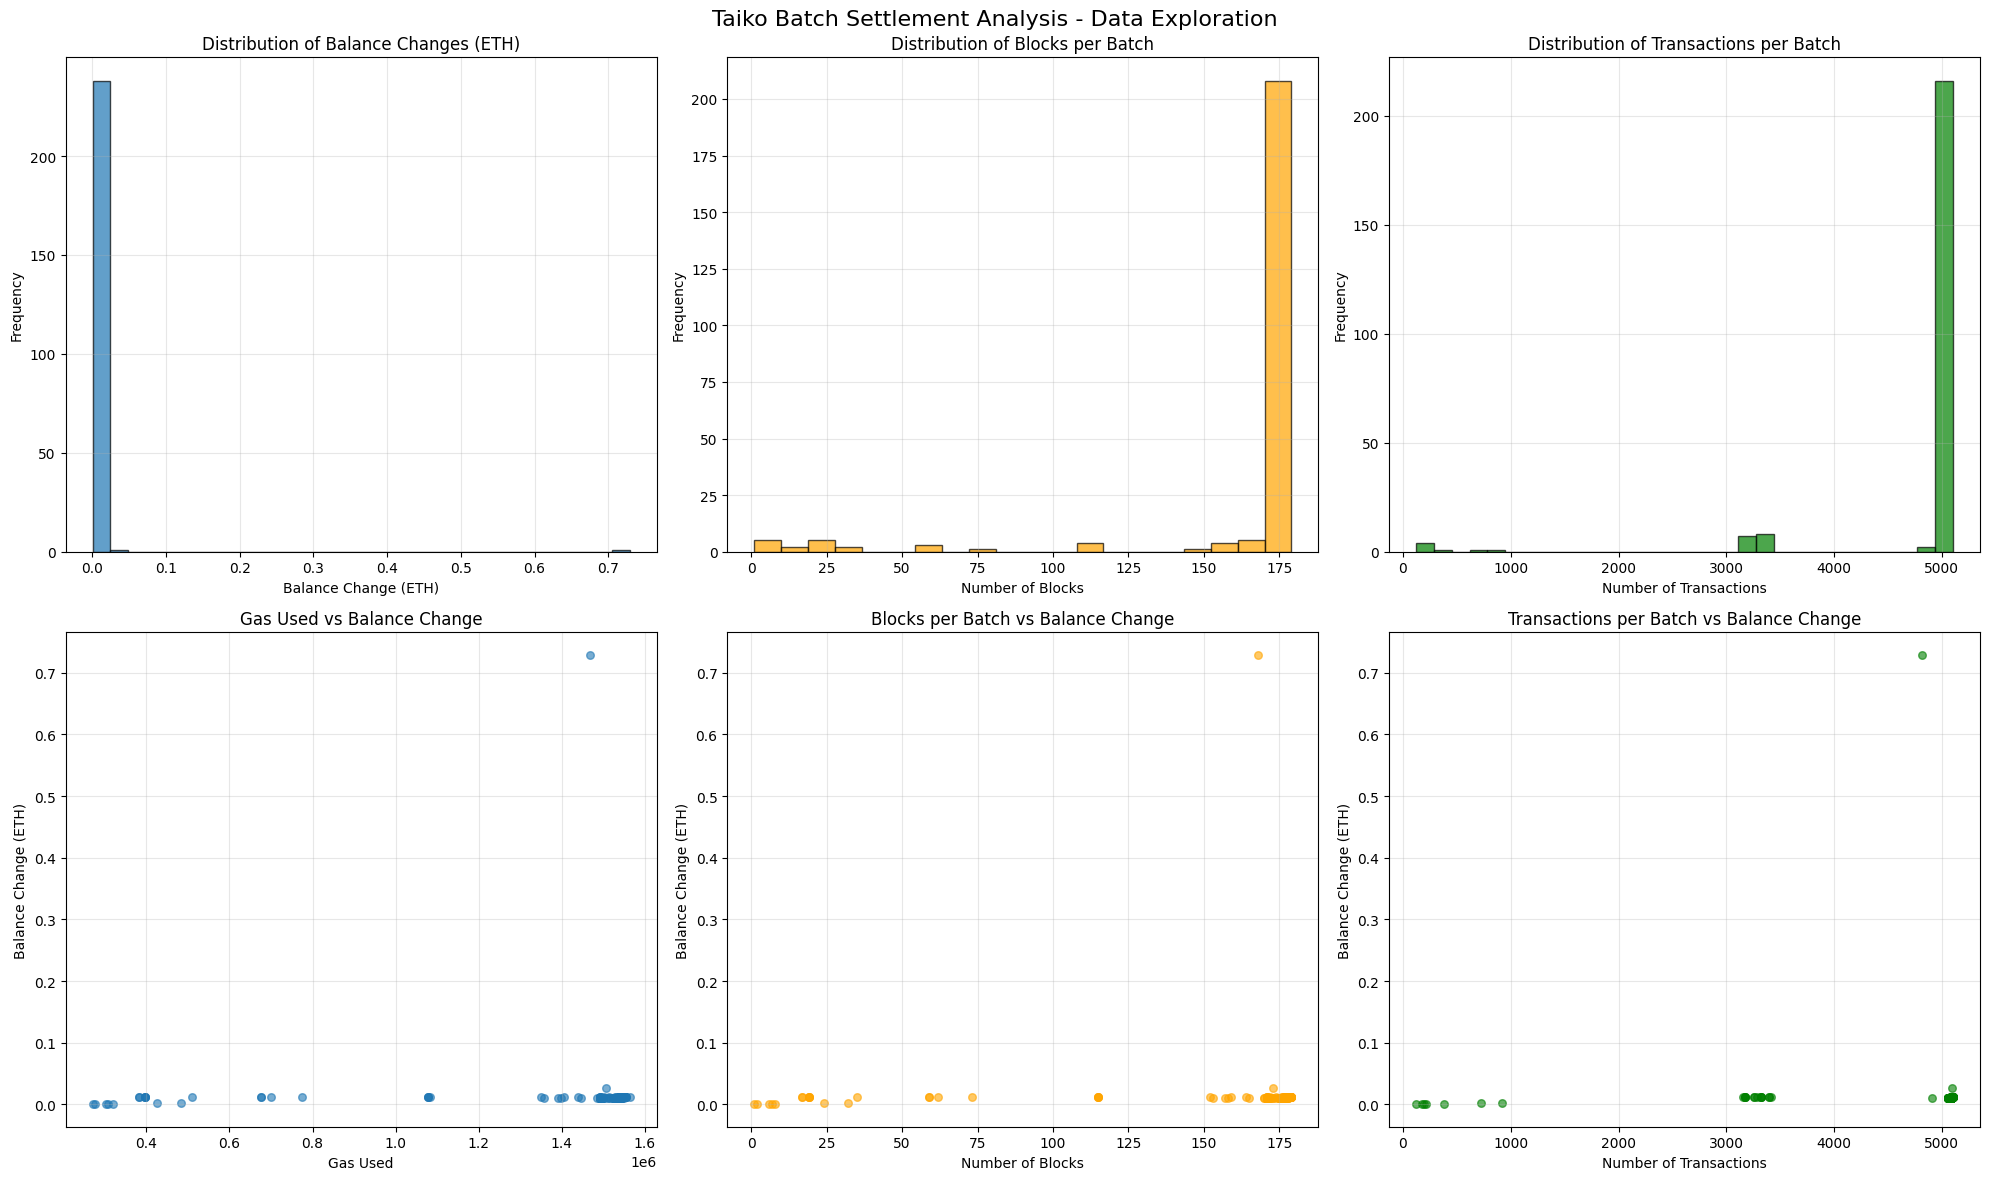

In [54]:
# Create comprehensive visualizations
plt.style.use('default')

# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Taiko Batch Settlement Analysis - Data Exploration', fontsize=16)

# 1. Distribution of balance changes (L2 revenue per batch)
axes[0, 0].hist(final_df['balance_change'] / 1e18, bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Balance Changes (ETH)')
axes[0, 0].set_xlabel('Balance Change (ETH)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Number of blocks per batch
axes[0, 1].hist(final_df['num_blocks'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].set_title('Distribution of Blocks per Batch')
axes[0, 1].set_xlabel('Number of Blocks')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Number of transactions per batch
axes[0, 2].hist(final_df['num_transactions'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 2].set_title('Distribution of Transactions per Batch')
axes[0, 2].set_xlabel('Number of Transactions')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# 4. Gas used vs Balance change
axes[1, 0].scatter(final_df['gas_used'], final_df['balance_change'] / 1e18, alpha=0.6, s=30)
axes[1, 0].set_title('Gas Used vs Balance Change')
axes[1, 0].set_xlabel('Gas Used')
axes[1, 0].set_ylabel('Balance Change (ETH)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Blocks per batch vs Balance change
axes[1, 1].scatter(final_df['num_blocks'], final_df['balance_change'] / 1e18, alpha=0.6, s=30, color='orange')
axes[1, 1].set_title('Blocks per Batch vs Balance Change')
axes[1, 1].set_xlabel('Number of Blocks')
axes[1, 1].set_ylabel('Balance Change (ETH)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Transactions per batch vs Balance change
axes[1, 2].scatter(final_df['num_transactions'], final_df['balance_change'] / 1e18, alpha=0.6, s=30, color='green')
axes[1, 2].set_title('Transactions per Batch vs Balance Change')
axes[1, 2].set_xlabel('Number of Transactions')
axes[1, 2].set_ylabel('Balance Change (ETH)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [50]:
# Create mainnet gas cost column by replacing Holesky gas cost with mainnet base fees

DAY_OFFSET = 1

# First, ensure both DataFrames have proper timestamp columns
final_df['timestamp_dt'] = pd.to_datetime(final_df['timestamp'] - (DAY_OFFSET * 24 * 3600), unit='s')

# For each transaction in new_df, find the closest mainnet base fee from basefee_df
def get_closest_mainnet_basefee(timestamp):
    """Find the closest mainnet base fee for a given timestamp"""
    time_diff = abs(basefee_df['timestamp'] - timestamp)
    closest_idx = time_diff.idxmin()
    return basefee_df.loc[closest_idx, 'base_fee_per_gas']

# Add the closest mainnet base fee to each row
final_df['mainnet_base_fee'] = final_df['timestamp_dt'].apply(get_closest_mainnet_basefee)

# Calculate mainnet gas cost using mainnet base fee + priority fee
# Assuming similar priority fee structure as Holesky
final_df['mainnet_gas_cost'] = (final_df['mainnet_base_fee'] + final_df['max_priority_fee_per_gas']) * final_df['gas_used']

final_df['profit'] = final_df['balance_change'] - final_df['mainnet_gas_cost']
final_df['effective_gas_price'] = final_df['mainnet_gas_cost'] / final_df['gas_used']

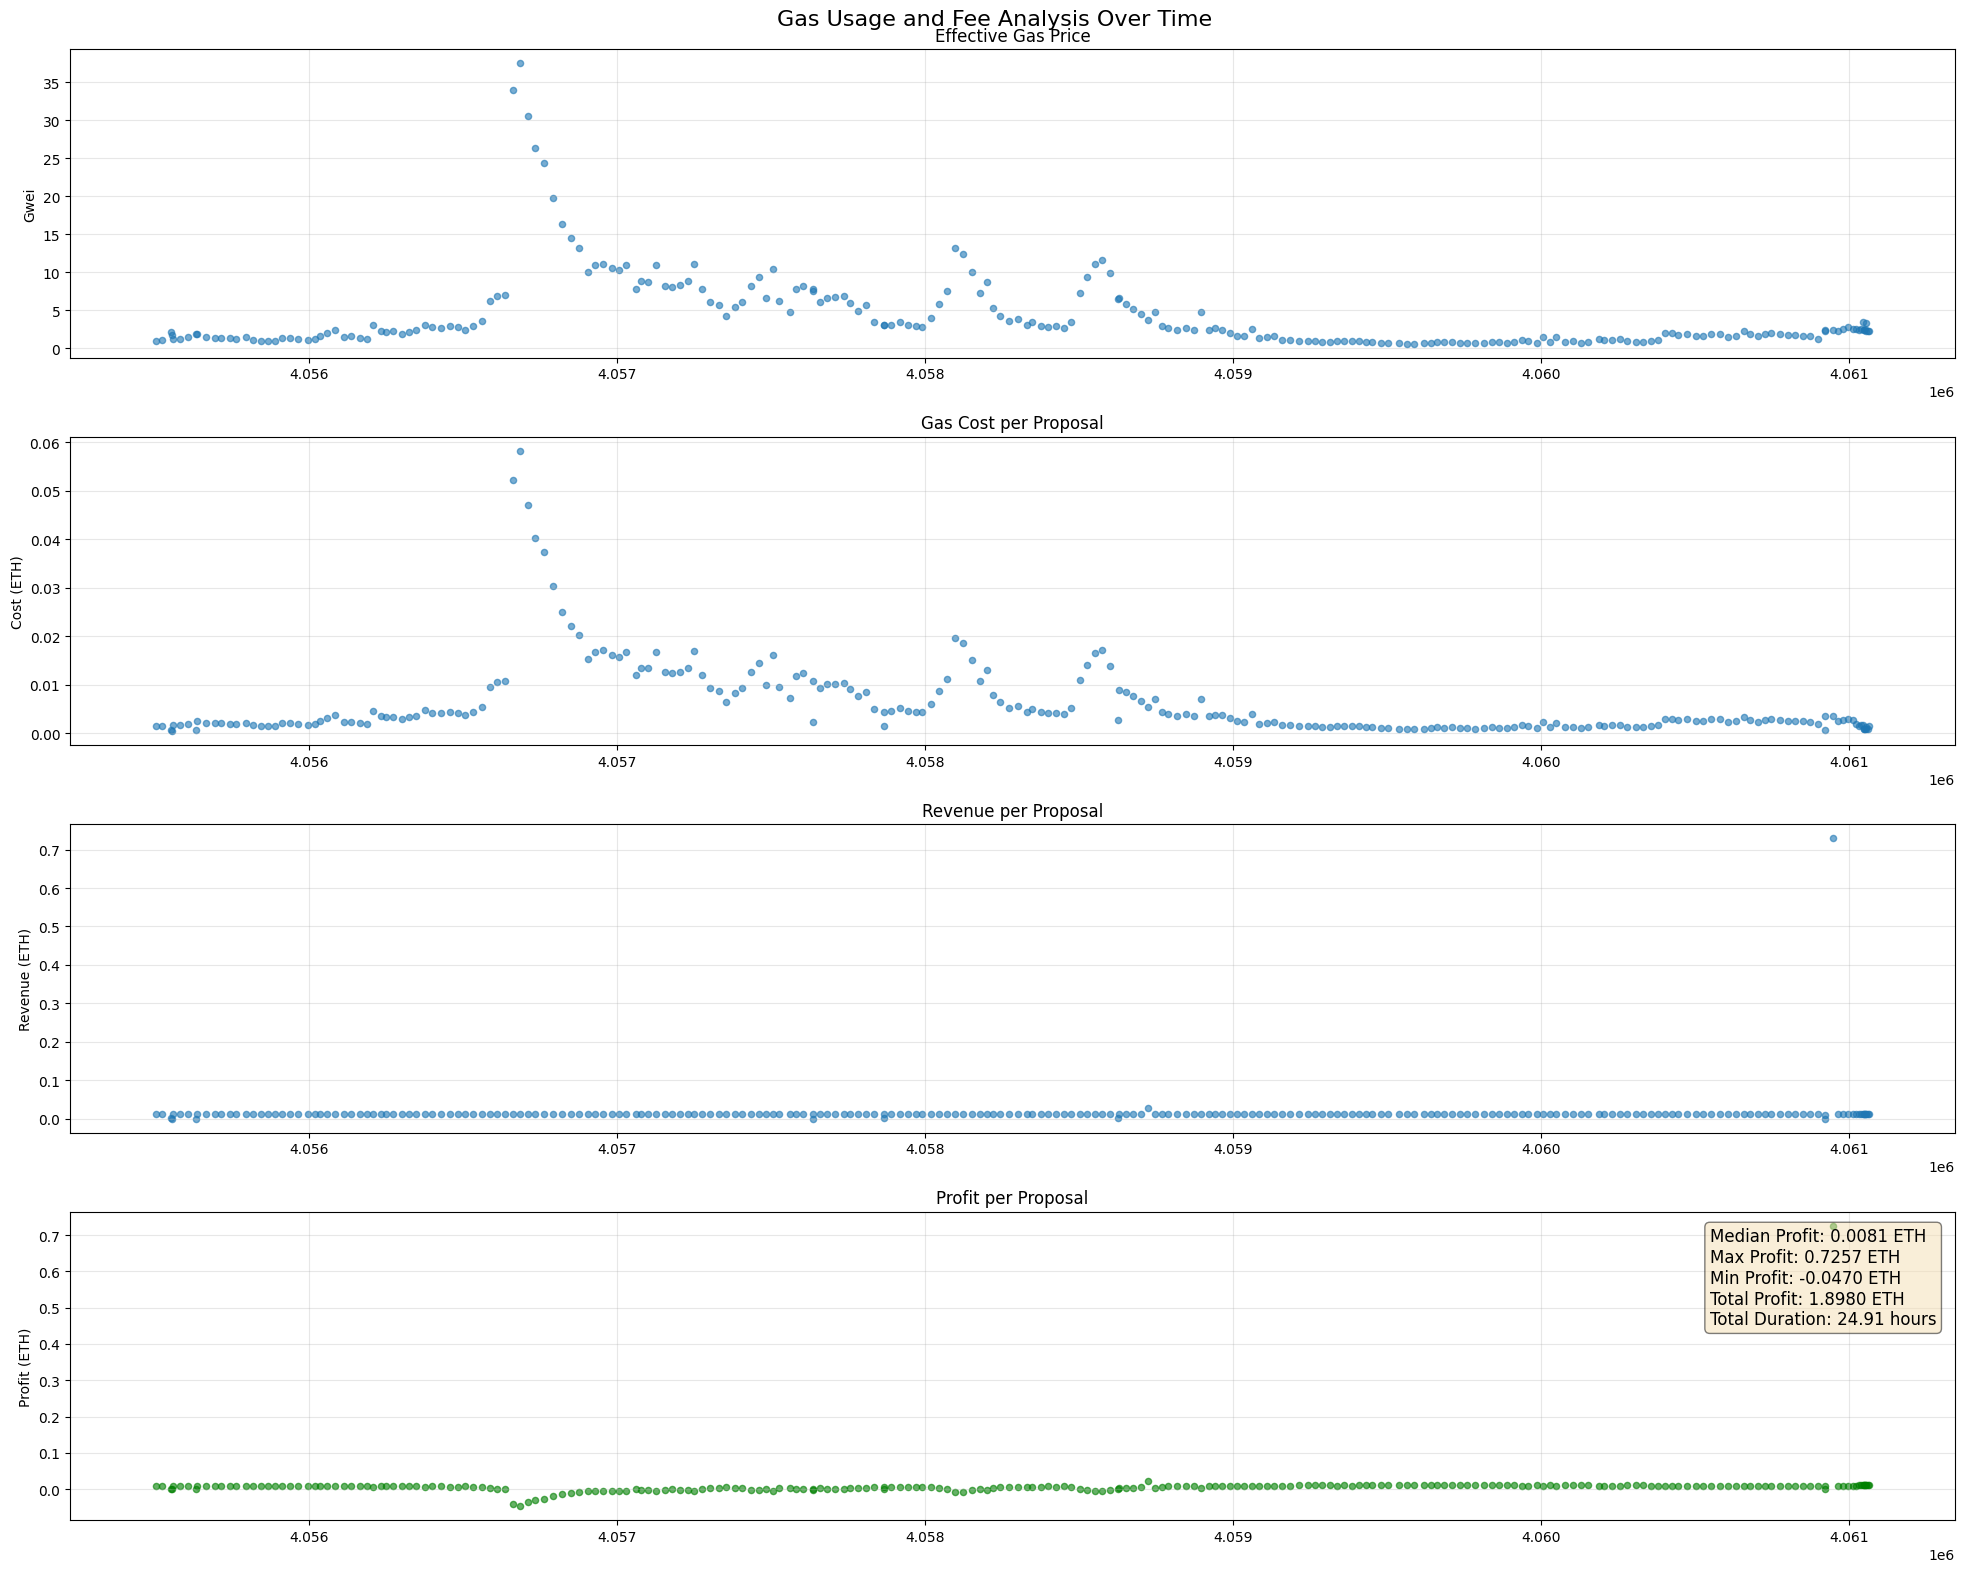

In [55]:
plt.style.use('default')

# Basic data exploration and cleaning
# Use block_number instead of timestamp for time series
# Create figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(20, 16))
fig.suptitle('Gas Usage and Fee Analysis Over Time', fontsize=16)

axes[0].scatter(final_df['block_number'], final_df['effective_gas_price'] / 1e9, alpha=0.6, s=20)
axes[0].set_ylabel('Gwei')
axes[0].set_title('Effective Gas Price')
axes[0].grid(True, alpha=0.3)

# Plot 1: Gas Used over time
axes[1].scatter(final_df['block_number'], final_df['mainnet_gas_cost'] / 1e18, alpha=0.6, s=20)
axes[1].set_ylabel('Cost (ETH)')
axes[1].set_title('Gas Cost per Proposal')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(final_df['block_number'], final_df['balance_change'] / 1e18, alpha=0.6, s=20)
axes[2].set_ylabel('Revenue (ETH)')
axes[2].set_title('Revenue per Proposal')
axes[2].grid(True, alpha=0.3)

axes[3].scatter(final_df['block_number'], final_df['profit'] / 1e18, alpha=0.6, s=20, color='green')
axes[3].set_ylabel('Profit (ETH)')
axes[3].set_title('Profit per Proposal')
axes[3].grid(True, alpha=0.3)

median_profit = final_df['profit'].median() / 1e18
max_profit = final_df['profit'].max() / 1e18
min_profit = final_df['profit'].min() / 1e18
total_profit = final_df['profit'].sum() / 1e18
total_duration = (final_df['timestamp'].max() - final_df['timestamp'].min()) / 3600

text = '\n'.join([
    f'Median Profit: {median_profit:.4f} ETH',
    f'Max Profit: {max_profit:.4f} ETH',
    f'Min Profit: {min_profit:.4f} ETH',
    f'Total Profit: {total_profit:.4f} ETH',
    f'Total Duration: {total_duration:.2f} hours',
])

axes[3].text(0.87, 0.95, text, fontsize=12, va='top', transform=axes[3].transAxes, bbox=dict(facecolor='wheat', alpha=0.5, boxstyle='round'))

plt.tight_layout()
plt.show()

In [52]:
# Breakeven Analysis: Calculate maximum mainnet base fee for break even

# For breakeven: profit = 0, which means: balance_change = mainnet_gas_cost
# Since mainnet_gas_cost = (base_fee + priority_fee) * gas_used
# We can solve for breakeven_base_fee = (balance_change / gas_used) - priority_fee

final_df['breakeven_base_fee'] = (final_df['balance_change'] / final_df['gas_used']) - final_df['max_priority_fee_per_gas']
final_df['breakeven_base_fee_gwei'] = final_df['breakeven_base_fee'] / 1e9

# Filter out negative breakeven values (cases where you can't break even even with 0 base fee)
profitable_batches = final_df[final_df['breakeven_base_fee'] > 0].copy()
unprofitable_batches = final_df[final_df['breakeven_base_fee'] <= 0].copy()

print("="*80)
print("BREAKEVEN ANALYSIS RESULTS")
print("="*80)
print(f"Total batches analyzed: {len(final_df)}")
print(f"Batches that can break even: {len(profitable_batches)} ({len(profitable_batches)/len(final_df)*100:.1f}%)")
print(f"Batches that cannot break even: {len(unprofitable_batches)} ({len(unprofitable_batches)/len(final_df)*100:.1f}%)")
print()

if len(profitable_batches) > 0:
    print("BREAKEVEN BASE FEE STATISTICS (for profitable batches):")
    print(f"Minimum breakeven base fee: {profitable_batches['breakeven_base_fee_gwei'].min():.2f} Gwei")
    print(f"Maximum breakeven base fee: {profitable_batches['breakeven_base_fee_gwei'].max():.2f} Gwei")
    print(f"Average breakeven base fee: {profitable_batches['breakeven_base_fee_gwei'].mean():.2f} Gwei")
    print(f"Median breakeven base fee: {profitable_batches['breakeven_base_fee_gwei'].median():.2f} Gwei")
    print()
    
    # Percentile analysis
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("BREAKEVEN BASE FEE PERCENTILES:")
    for p in percentiles:
        value = np.percentile(profitable_batches['breakeven_base_fee_gwei'], p)
        print(f"{p:2d}th percentile: {value:7.2f} Gwei")
    print()
    
    # Conservative analysis - what % of batches would be profitable at different base fee levels
    test_base_fees = [5, 10, 15, 20, 25, 30, 40, 50, 75, 100]
    print("PROFITABILITY AT DIFFERENT BASE FEE LEVELS:")
    print("Base Fee (Gwei) | % of Batches Profitable")
    print("-" * 40)
    for base_fee in test_base_fees:
        profitable_count = len(profitable_batches[profitable_batches['breakeven_base_fee_gwei'] >= base_fee])
        percentage = profitable_count / len(final_df) * 100
        print(f"{base_fee:12.0f} | {percentage:18.1f}%")

# Display current vs breakeven comparison
final_df['current_vs_breakeven'] = final_df['mainnet_base_fee'] / 1e9 - final_df['breakeven_base_fee_gwei']

print()
print("CURRENT MAINNET CONDITIONS vs BREAKEVEN:")
print(f"Current average mainnet base fee: {final_df['mainnet_base_fee'].mean()/1e9:.2f} Gwei")
print(f"Average breakeven base fee: {final_df['breakeven_base_fee_gwei'].mean():.2f} Gwei")
current_profitable = len(final_df[final_df['profit'] > 0])
print(f"Batches profitable under current conditions: {current_profitable}/{len(final_df)} ({current_profitable/len(final_df)*100:.1f}%)")

final_df[['balance_change', 'mainnet_gas_cost', 'profit', 'breakeven_base_fee_gwei', 'mainnet_base_fee']].head(10)


BREAKEVEN ANALYSIS RESULTS
Total batches analyzed: 240
Batches that can break even: 240 (100.0%)
Batches that cannot break even: 0 (0.0%)

BREAKEVEN BASE FEE STATISTICS (for profitable batches):
Minimum breakeven base fee: 0.31 Gwei
Maximum breakeven base fee: 495.49 Gwei
Average breakeven base fee: 9.97 Gwei
Median breakeven base fee: 7.28 Gwei

BREAKEVEN BASE FEE PERCENTILES:
10th percentile:    7.20 Gwei
25th percentile:    7.26 Gwei
50th percentile:    7.28 Gwei
75th percentile:    7.44 Gwei
90th percentile:    7.53 Gwei
95th percentile:   13.67 Gwei
99th percentile:   29.27 Gwei

PROFITABILITY AT DIFFERENT BASE FEE LEVELS:
Base Fee (Gwei) | % of Batches Profitable
----------------------------------------
           5 |               97.1%
          10 |                5.4%
          15 |                5.0%
          20 |                3.3%
          25 |                2.9%
          30 |                0.4%
          40 |                0.4%
          50 |                0.4%
 

,balance_change,mainnet_gas_cost,profit,breakeven_base_fee_gwei,mainnet_base_fee
0,11152890000000000,1397632823081013,9755257176918987,7.501826,931350082
1,11161710000000000,1563486594709871,9598223405290129,7.470091,1037780538
2,848925000000000,597743278866846,251181721133154,2.062036,1156034363
3,264600000000000,448146523063496,-183546523063496,0.477798,1156666926
4,11205810000000000,1758773248239117,9447036751760883,7.475309,1156403117
5,11157300000000000,1799653516755840,9357646483244160,7.43745,1182874028
6,11144070000000000,1992244742739016,9151825257260984,7.962419,1415243121
7,436590000000000,581095031199190,-144505031199190,1.4038,1871747864
8,11155321845990000,2580341781209305,8574980064780695,8.206126,1890475262
9,11152890000000000,2102453679974912,9050436320025088,7.431769,1392862823


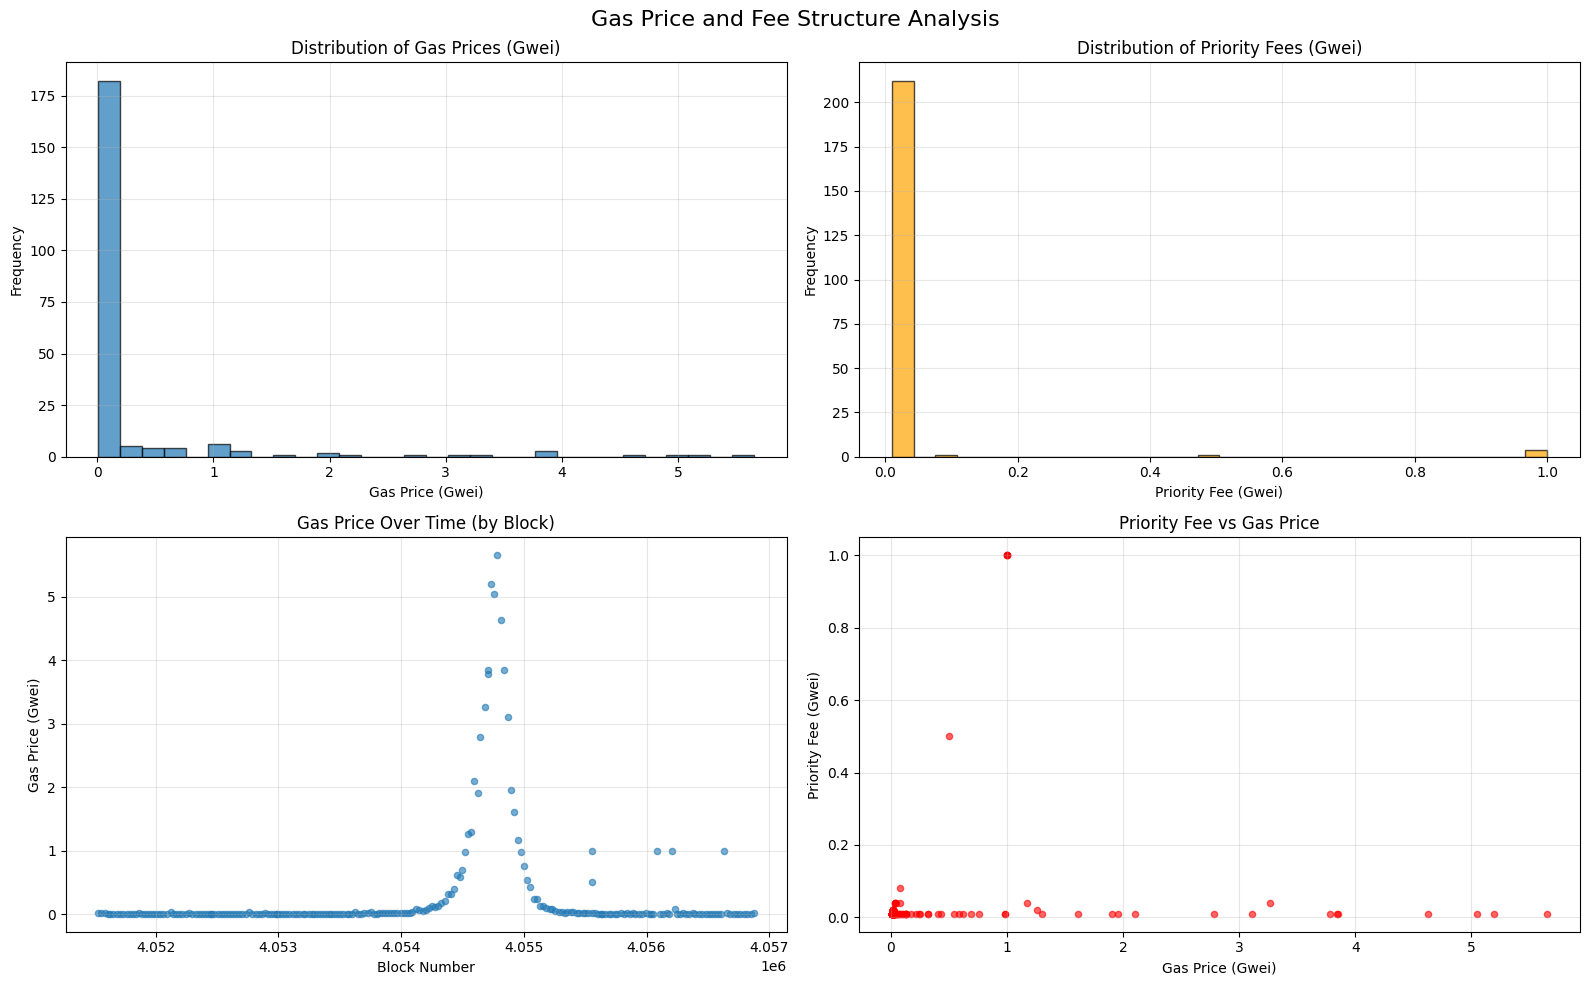

In [220]:
# Gas price and fee analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Gas Price and Fee Structure Analysis', fontsize=16)

# Convert to Gwei for better readability
new_df['gas_price_gwei'] = new_df['gas_price'] / 1e9
new_df['max_priority_fee_gwei'] = new_df['max_priority_fee_per_gas'] / 1e9
new_df['max_fee_gwei'] = new_df['max_fee_per_gas'] / 1e9

# 1. Gas price distribution
axes[0, 0].hist(new_df['gas_price_gwei'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Gas Prices (Gwei)')
axes[0, 0].set_xlabel('Gas Price (Gwei)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Priority fee distribution
axes[0, 1].hist(new_df['max_priority_fee_gwei'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].set_title('Distribution of Priority Fees (Gwei)')
axes[0, 1].set_xlabel('Priority Fee (Gwei)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Gas price vs Block number (time series)
axes[1, 0].scatter(new_df['block_number'], new_df['gas_price_gwei'], alpha=0.6, s=20)
axes[1, 0].set_title('Gas Price Over Time (by Block)')
axes[1, 0].set_xlabel('Block Number')
axes[1, 0].set_ylabel('Gas Price (Gwei)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Priority fee vs Gas price
axes[1, 1].scatter(new_df['gas_price_gwei'], new_df['max_priority_fee_gwei'], alpha=0.6, s=20, color='red')
axes[1, 1].set_title('Priority Fee vs Gas Price')
axes[1, 1].set_xlabel('Gas Price (Gwei)')
axes[1, 1].set_ylabel('Priority Fee (Gwei)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


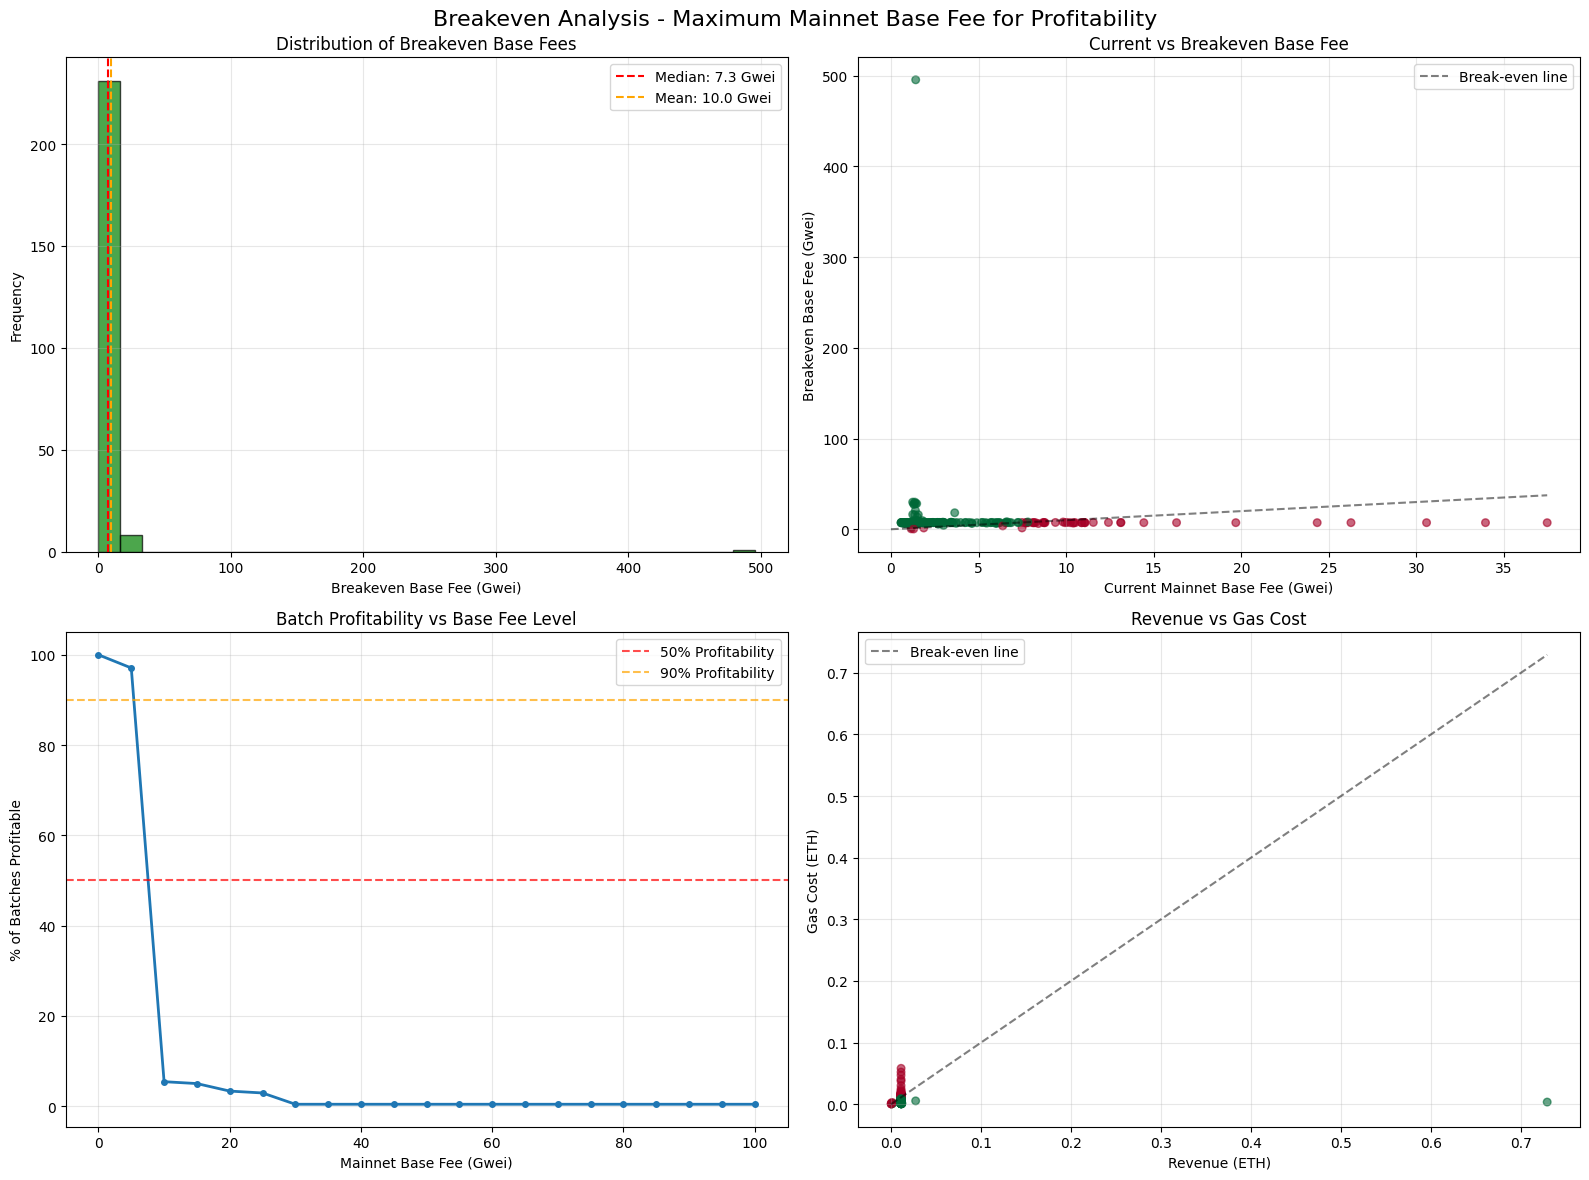


BREAKEVEN RECOMMENDATIONS
🔴 VERY CONSERVATIVE (90% of batches profitable): 7.2 Gwei
🟡 CONSERVATIVE (75% of batches profitable): 7.3 Gwei
🟢 MODERATE (50% of batches profitable): 7.3 Gwei

Historical mainnet base fee context:
- Your sampled average: 4.0 Gwei
- Current mainnet conditions make 196/240 batches profitable
✅ Current average mainnet base fee (4.0 Gwei) is below your median breakeven point


In [53]:
# Visualize Breakeven Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Breakeven Analysis - Maximum Mainnet Base Fee for Profitability', fontsize=16)

# 1. Distribution of breakeven base fees
if len(profitable_batches) > 0:
    axes[0, 0].hist(profitable_batches['breakeven_base_fee_gwei'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 0].axvline(np.median(profitable_batches['breakeven_base_fee_gwei']), color='red', linestyle='--', 
                       label=f'Median: {np.median(profitable_batches["breakeven_base_fee_gwei"]):.1f} Gwei')
    axes[0, 0].axvline(np.mean(profitable_batches['breakeven_base_fee_gwei']), color='orange', linestyle='--', 
                       label=f'Mean: {np.mean(profitable_batches["breakeven_base_fee_gwei"]):.1f} Gwei')
    axes[0, 0].set_title('Distribution of Breakeven Base Fees')
    axes[0, 0].set_xlabel('Breakeven Base Fee (Gwei)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Breakeven vs Current mainnet base fee
axes[0, 1].scatter(final_df['mainnet_base_fee'] / 1e9, final_df['breakeven_base_fee_gwei'], 
                   alpha=0.6, s=30, c=final_df['profit'] > 0, cmap='RdYlGn')
axes[0, 1].plot([0, final_df['mainnet_base_fee'].max() / 1e9], [0, final_df['mainnet_base_fee'].max() / 1e9], 
                'k--', alpha=0.5, label='Break-even line')
axes[0, 1].set_title('Current vs Breakeven Base Fee')
axes[0, 1].set_xlabel('Current Mainnet Base Fee (Gwei)')
axes[0, 1].set_ylabel('Breakeven Base Fee (Gwei)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Profitability percentage at different base fee levels
test_base_fees = np.arange(0, 101, 5)
profitability_pct = []
for base_fee in test_base_fees:
    if len(profitable_batches) > 0:
        profitable_count = len(profitable_batches[profitable_batches['breakeven_base_fee_gwei'] >= base_fee])
        percentage = profitable_count / len(final_df) * 100
    else:
        percentage = 0
    profitability_pct.append(percentage)

axes[1, 0].plot(test_base_fees, profitability_pct, marker='o', linewidth=2, markersize=4)
axes[1, 0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Profitability')
axes[1, 0].axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% Profitability')
axes[1, 0].set_title('Batch Profitability vs Base Fee Level')
axes[1, 0].set_xlabel('Mainnet Base Fee (Gwei)')
axes[1, 0].set_ylabel('% of Batches Profitable')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Revenue vs Cost relationship
axes[1, 1].scatter(final_df['balance_change'] / 1e18, final_df['mainnet_gas_cost'] / 1e18, 
                   alpha=0.6, s=30, c=final_df['profit'] > 0, cmap='RdYlGn')
max_val = max(final_df['balance_change'].max(), final_df['mainnet_gas_cost'].max()) / 1e18
axes[1, 1].plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Break-even line')
axes[1, 1].set_title('Revenue vs Gas Cost')
axes[1, 1].set_xlabel('Revenue (ETH)')
axes[1, 1].set_ylabel('Gas Cost (ETH)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary recommendations
print("\n" + "="*80)
print("BREAKEVEN RECOMMENDATIONS")
print("="*80)

if len(profitable_batches) > 0:
    safe_base_fee = np.percentile(profitable_batches['breakeven_base_fee_gwei'].values, 10)
    conservative_base_fee = np.percentile(profitable_batches['breakeven_base_fee_gwei'].values, 25)
    median_base_fee = np.median(profitable_batches['breakeven_base_fee_gwei'])
    
    print(f"🔴 VERY CONSERVATIVE (90% of batches profitable): {safe_base_fee:.1f} Gwei")
    print(f"🟡 CONSERVATIVE (75% of batches profitable): {conservative_base_fee:.1f} Gwei") 
    print(f"🟢 MODERATE (50% of batches profitable): {median_base_fee:.1f} Gwei")
    print()
    print("Historical mainnet base fee context:")
    print(f"- Your sampled average: {final_df['mainnet_base_fee'].mean()/1e9:.1f} Gwei")
    print(f"- Current mainnet conditions make {current_profitable}/{len(final_df)} batches profitable")
    
    # Current market comparison
    current_avg = final_df['mainnet_base_fee'].mean() / 1e9
    if current_avg > median_base_fee:
        print(f"⚠️  Current average mainnet base fee ({current_avg:.1f} Gwei) is ABOVE your median breakeven point!")
    else:
        print(f"✅ Current average mainnet base fee ({current_avg:.1f} Gwei) is below your median breakeven point")
        
else:
    print("⚠️  WARNING: No batches can break even at any mainnet base fee level!")
    print("This suggests the revenue model needs adjustment or gas usage optimization.")
